In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime
import ModelsPlot as model_plot

In [2]:
monthly_data = pd.read_csv('USA_Marco.csv',index_col=0)
monthly_data = monthly_data.loc[[x for x in monthly_data.index if x == x and '/'  in x]]
monthly_data.index = [pd.to_datetime(x) for x in monthly_data.index]
monthly_data['Dates'] = [int(x.strftime('%Y%m')) for x in monthly_data.index]

In [3]:
merged = monthly_data
Ys_table = pd.read_csv('US_Marco_predictors.csv')
used_Ytable = Ys_table[['Dates','Vol']]

merged = pd.merge(merged,used_Ytable,on = 'Dates')

st_month = 201001
ed_month = 201912
Xtodrop = ['Dates','Vol','y']

merged['y'] = merged['Vol'].shift(-1)
whole_data = merged[(merged['Dates']>=st_month) & (merged['Dates']<=ed_month)].reset_index(drop = True)
whole_data = whole_data.fillna(0)

In [4]:
whole_data.drop(columns = ['Dates','Vol','y']).describe().T

,count,mean,std,min,25%,50%,75%,max
RPI,120.0,1.494266e+04,1230.616509,1.285230e+04,1.390553e+04,1.503529e+04,1.598108e+04,1.700896e+04
W875RX1,120.0,1.238146e+04,1076.180625,1.043750e+04,1.153440e+04,1.248280e+04,1.328825e+04,1.415250e+04
DPCERA3M086SBEA,120.0,1.073084e+02,7.984293,9.528700e+01,9.994650e+01,1.067425e+02,1.141165e+02,1.213850e+02
CMRMTSPLx,120.0,1.363940e+06,100433.398090,1.159614e+06,1.277268e+06,1.378559e+06,1.439420e+06,1.525606e+06
RETAILx,120.0,4.389027e+05,48641.933046,3.459590e+05,4.013280e+05,4.399220e+05,4.740600e+05,5.238620e+05
...,...,...,...,...,...,...,...,...
MZMSL,120.0,1.298053e+04,2202.160625,9.422600e+03,1.107620e+04,1.298770e+04,1.494400e+04,1.702050e+04
DTCOLNVHFNM,120.0,2.997012e+05,24310.262118,2.185536e+05,2.890769e+05,3.039856e+05,3.141505e+05,3.434730e+05
DTCTHFNM,120.0,7.816260e+05,66062.613964,6.421238e+05,7.282148e+05,7.739991e+05,8.377405e+05,8.968665e+05
INVEST,120.0,2.972592e+03,426.982520,2.294189e+03,2.631631e+03,2.945876e+03,3.367402e+03,3.824323e+03


In [8]:
def Norm(in_df,no_Norm):
    op_df = in_df.copy()
    for col in op_df.columns:
        if col in no_Norm:
            continue
        else:
            col_max = max(op_df[col])
            col_min = min(op_df[col])
            if col_max == col_min:
                continue
            op_df[col] = (op_df[col] - col_min) / (col_max - col_min)
    return op_df

In [31]:
all_month_list = list(whole_data['Dates'].values)
train_month_n = 24
test_month_n = 12
oos_month_n = 1

pls_op = []


for i in range(len(all_month_list)):
    if i < train_month_n + test_month_n + oos_month_n - 1:
        continue
    else:
        
        train_monthes = all_month_list[i-test_month_n-train_month_n:i-test_month_n]
        test_monthes = all_month_list[i-test_month_n:i]
        oos_month = all_month_list[i]
        print(oos_month)
        
        train_data = whole_data[whole_data['Dates'].apply(lambda x: True if x in train_monthes else False)]
        test_data = whole_data[whole_data['Dates'].apply(lambda x: True if x in test_monthes else False)]
        oos_data = whole_data[whole_data['Dates'] == oos_month]
        

        
        X_train = train_data.drop(columns = Xtodrop)
        y_train = train_data['y']
        
        X_test = test_data.drop(columns = Xtodrop)
        y_test = test_data['y']
        
        X_oos = oos_data.drop(columns = Xtodrop)
        y_oos = oos_data['y']
        
        to_Norm = pd.concat([train_data,test_data,oos_data])
        normed_data = Norm(to_Norm,Xtodrop)
        train_data_normed = normed_data[normed_data['Dates'].apply(lambda x: True if x in train_monthes else False)]
        test_data_normed = normed_data[normed_data['Dates'].apply(lambda x: True if x in test_monthes else False)]
        oos_data_normed = normed_data[normed_data['Dates'] == oos_month]
        
        X_train_normed = train_data_normed.drop(columns = Xtodrop)
        y_train = train_data['y']
        
        X_test_normed = test_data_normed.drop(columns = Xtodrop)
        y_test = test_data['y']
        
        X_oos_normed = oos_data_normed.drop(columns = Xtodrop)
        y_oos = oos_data['y']
        
        
        pls_result = model_plot.PLS_method(X_train,y_train,X_test,y_test,X_oos, test_data, oos_data)
        pls_op.append(pls_result)
       

201301
201302
201303
201304
201305
201306
201307
201308
201309
201310
201311
201312
201401
201402
201403
201404
201405
201406
201407
201408
201409
201410
201411
201412
201501
201502
201503
201504
201505
201506
201507
201508
201509
201510
201511
201512
201601
201602
201603
201604
201605
201606
201607
201608
201609
201610
201611
201612
201701
201702
201703
201704
201705
201706
201707
201708
201709
201710
201711
201712
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
201901
201902
201903
201904
201905
201906
201907
201908
201909
201910
201911
201912


# PLS

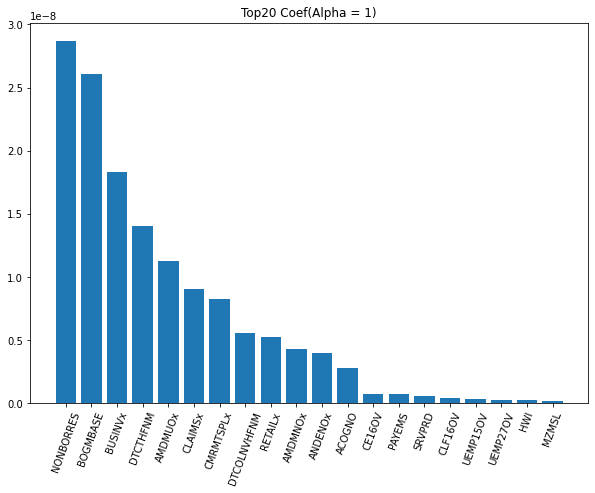

MSFE:  0.005048965195601305
R2: (n = 1) 0.31960219863916184


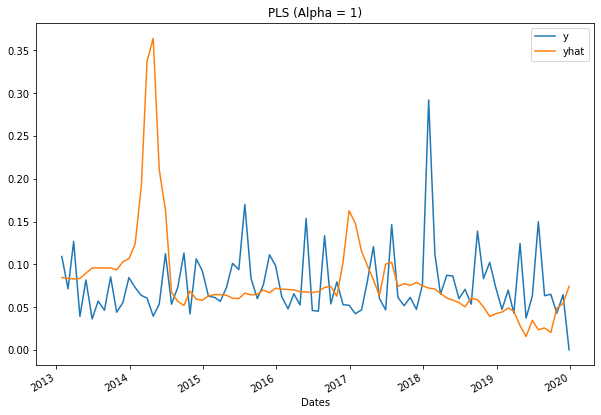

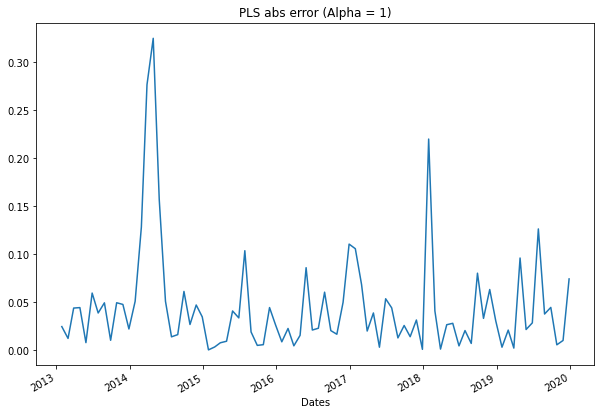

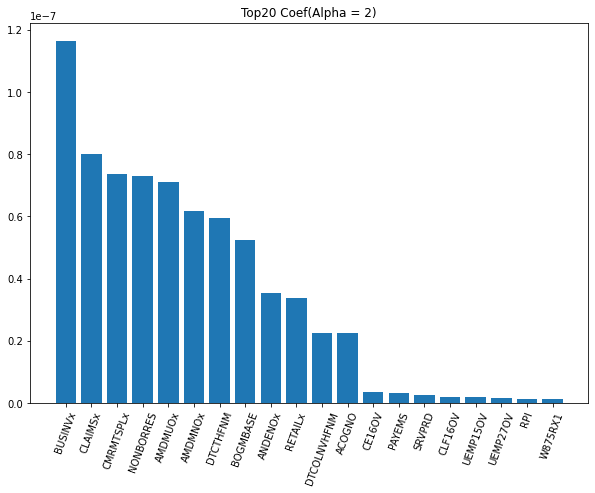

MSFE:  0.004737871804153216
R2: (n = 2) 0.36152509795793164


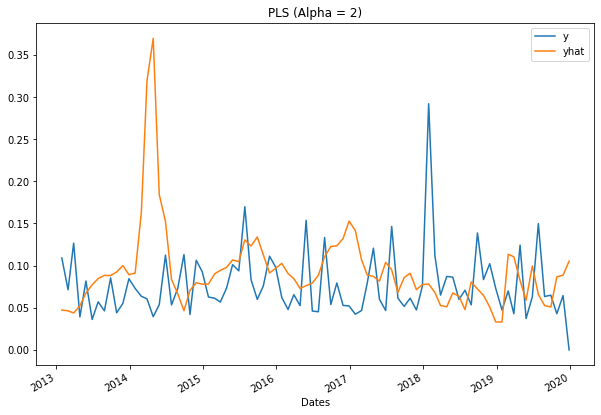

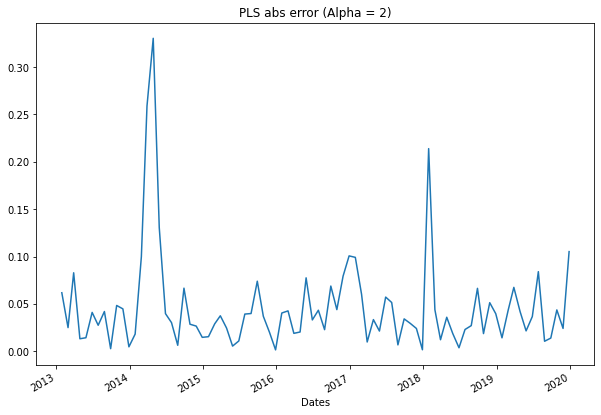

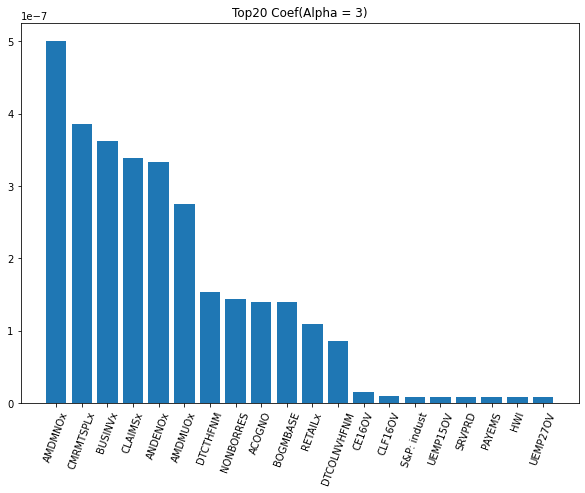

MSFE:  0.006829032405236307
R2: (n = 3) 0.0797206053246855


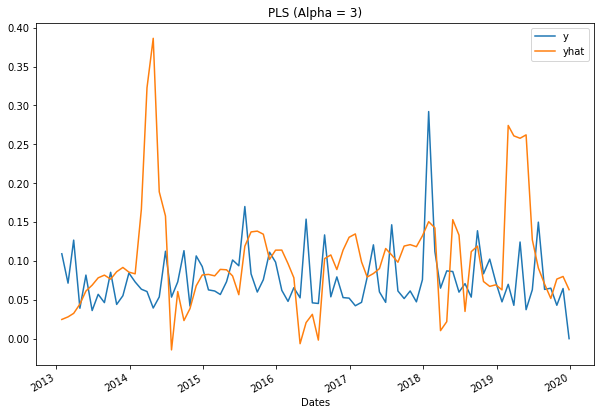

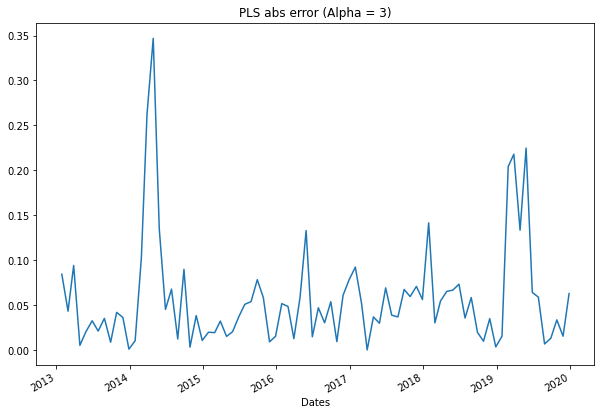

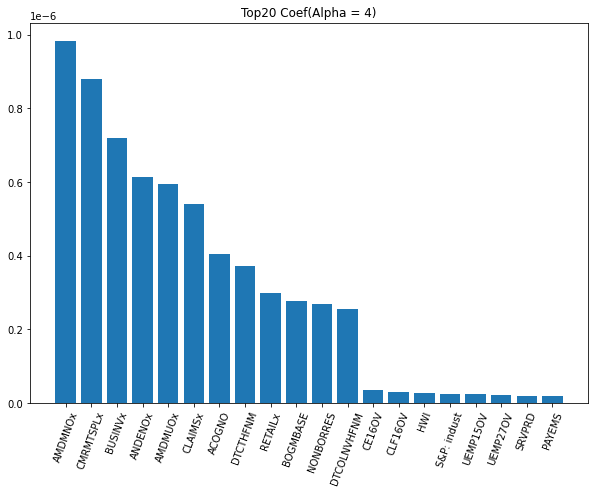

MSFE:  0.012963406766036644
R2: (n = 4) -0.7469467742502627


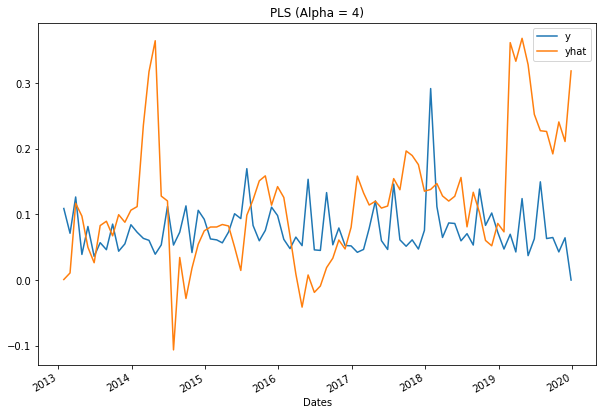

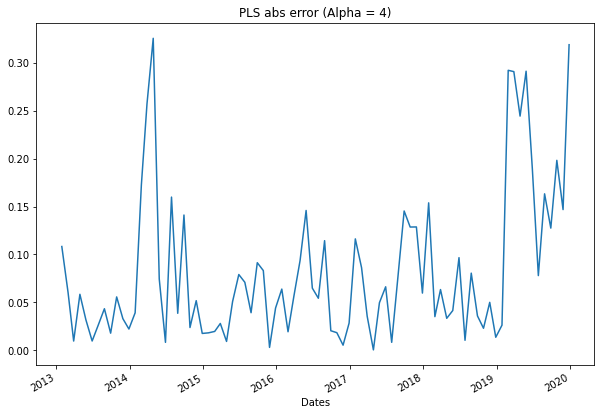

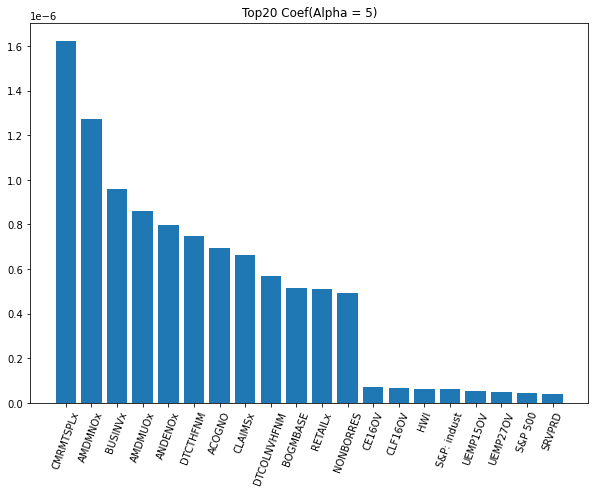

MSFE:  0.023768512475249123
R2: (n = 5) -2.2030412180037127


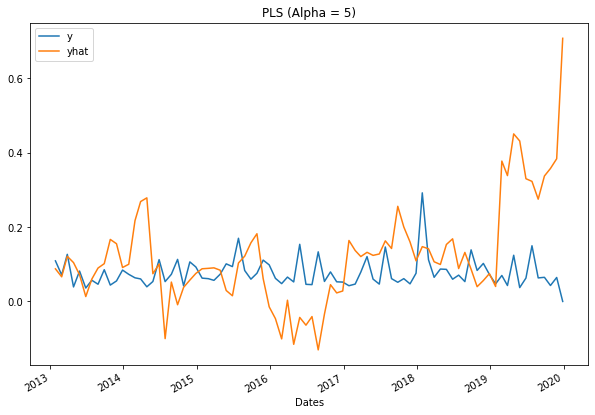

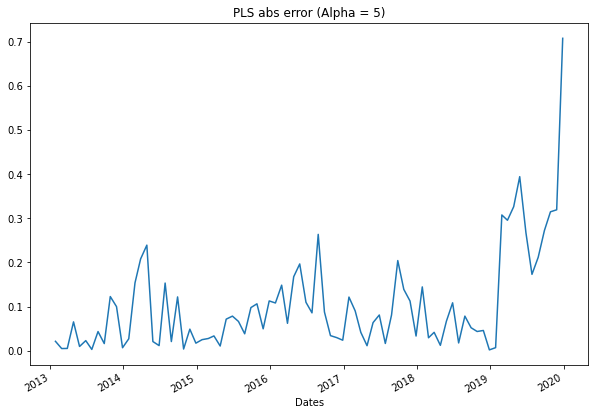

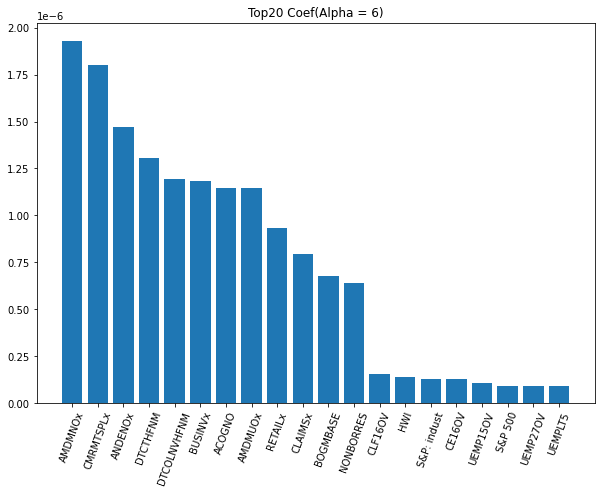

MSFE:  0.034904829435613155
R2: (n = 6) -3.70376964086754


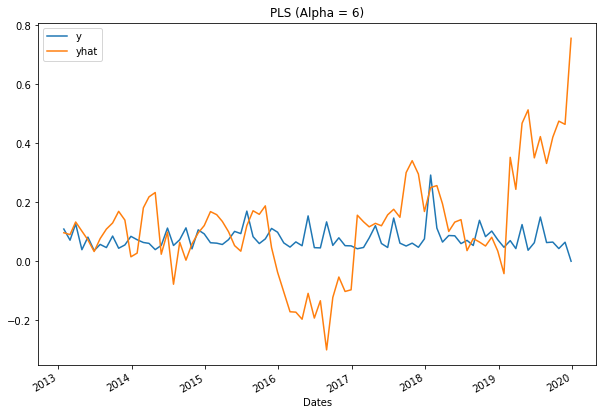

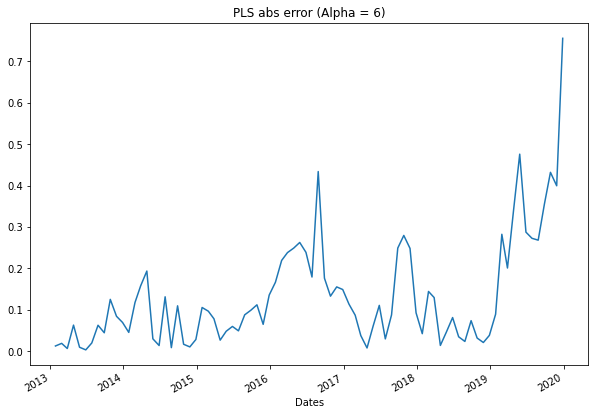

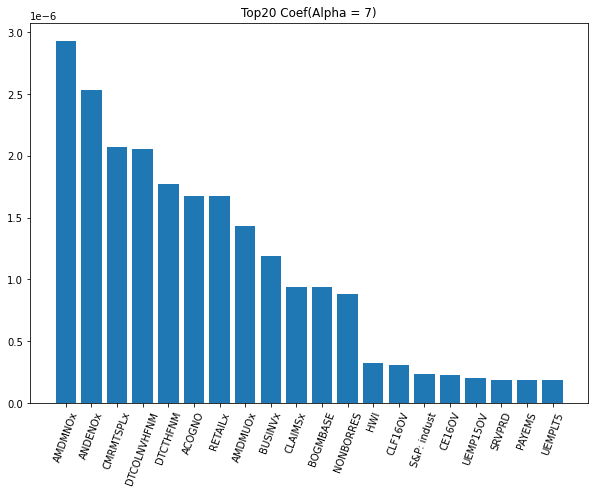

MSFE:  0.05038307242037921
R2: (n = 7) -5.789615371184445


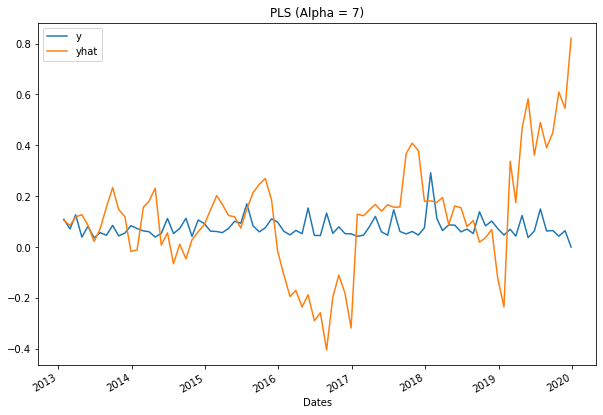

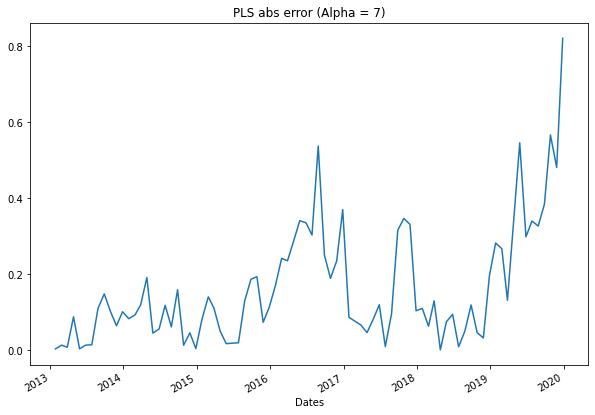

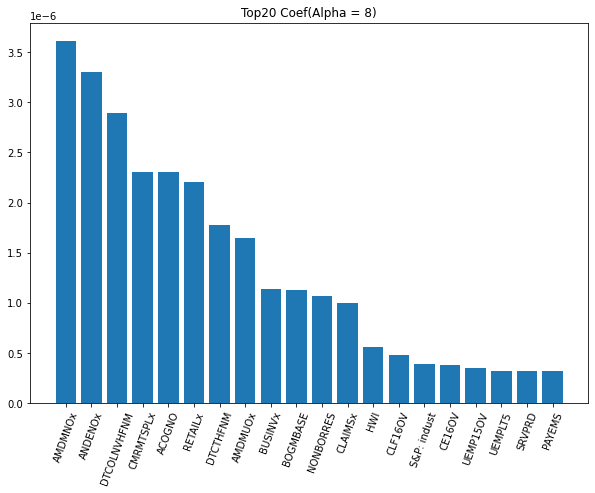

MSFE:  0.04791105807516007
R2: (n = 8) -5.456487084444643


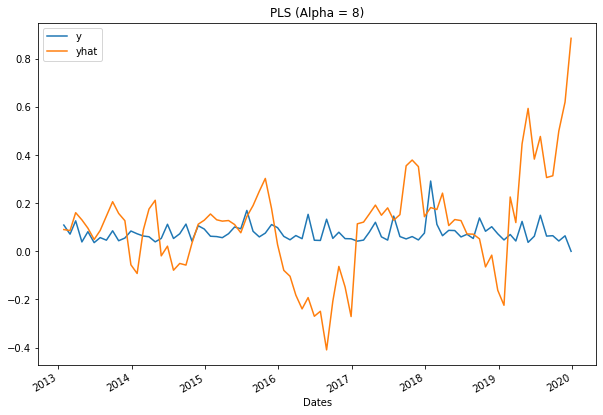

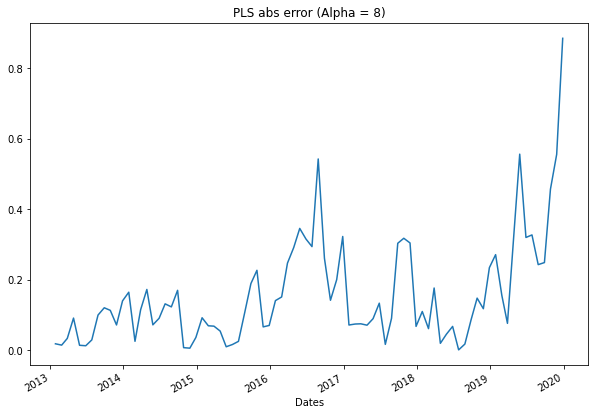

In [27]:
# deal with PLS
all_pred = []
all_best = []
all_coef = []
for i in range(len(all_month_list)):
    if i < train_month_n + test_month_n + oos_month_n - 1:
        continue
    else:
        result_idx = i - (train_month_n + test_month_n + oos_month_n - 1)
        oos_month = all_month_list[i]
        
        temp_tuning = pls_op[result_idx][0]
        temp_best = pls_op[result_idx][1]
        temp_coef = pls_op[result_idx][2]
        
        all_best.append(temp_best)
        
        temp_coef = pd.DataFrame(temp_coef).T
        temp_coef['n'] = temp_coef.index
        temp_coef['Dates'] = oos_month
        all_coef.append(temp_coef)
        all_pred.append(temp_tuning)
        
        
all_pred = pd.concat(all_pred)
all_pred['Dates'] = [datetime.datetime(year = int(x//100),month = int(x%100),day = 28) for x in all_pred['Dates']]
all_pred = all_pred.sort_values(['n','Dates'])
all_pred = all_pred.set_index(['n','Dates'])
        
     
all_coef = pd.concat(all_coef)
all_coef = all_coef.sort_values(['n','Dates'])
all_coef = all_coef.set_index(['n','Dates'])




for n in range(1,9):
    alpha_coef = all_coef.loc[n]
    plt.figure(figsize = (10,7))
    abs_coef = abs(alpha_coef).mean()
    toplot_coef = abs_coef.sort_values(ascending = False).head(20)
    plt.bar(x = list(toplot_coef.index), height = toplot_coef.values)
    plt.xticks(rotation=70)
    plt.title('Top20 Coef(Alpha = %s)'%n)
    plt.show()
    
    alpha_pred = all_pred.loc[n]
    
    msfe = np.sum((alpha_pred['yhat']-alpha_pred['y'])**2) / len(alpha_pred)
    print('MSFE: ', msfe)
    r2 = 1-np.sum((alpha_pred['yhat']-alpha_pred['y'])**2)/np.sum(alpha_pred['y']**2)
    print('R2: (n = %s)'%n, r2)
    
    alpha_pred[['y','yhat']].plot(figsize = (10,7),title = 'PLS (Alpha = %s)'%n)
    plt.show()
    
    abs(alpha_pred['y']- alpha_pred['yhat']).plot(figsize = (10,7),title = 'PLS abs error (Alpha = %s)'%n)
    plt.show()  
